In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython import get_ipython
ipython = get_ipython()

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Suppress rpy2 runtime warnings
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%%R

# Visualization
library(ggplot2)
library(ggalt)
library(ggExtra)
library(ggcorrplot)
library(ggthemes)
library(ggdendro)
library(GGally)
library(ggrepel)
theme_set(theme_light())

# Tidyverse library
library(scales)
library(dplyr)
library(tidyr)
library(forcats)
library(readr)
library(purrr)

# String manipulations
library(tools)
library(lubridate)

# Machine Learning Related
library(car)
library(caTools)
library(pROC)

# Misc
library(psych)

In [3]:
# (a) Load the dataset
import glob

all_files = glob.glob('../../Homework Data/Homework 3 Data/AreM/*/*.csv')

In [4]:
# Sort the files accordingly, to activity, then to instance number
import re

def sorting(s):
    activity, instance = s.split('/')[-2:]
    instance_num = int(re.search('\d+', instance)[0])
    return (activity, instance_num)

In [5]:
all_files = sorted(all_files, key=sorting)
all_files[:30] # Check to see if files are sorted properly

['../../Homework Data/Homework 3 Data/AreM/bending1/dataset1.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending1/dataset2.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending1/dataset3.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending1/dataset4.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending1/dataset5.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending1/dataset6.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending1/dataset7.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending2/dataset1.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending2/dataset2.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending2/dataset3.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending2/dataset4.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending2/dataset5.csv',
 '../../Homework Data/Homework 3 Data/AreM/bending2/dataset6.csv',
 '../../Homework Data/Homework 3 Data/AreM/cycling/dataset1.csv',
 '../../Homework Data/Homework 3 Data/AreM/cycling/dataset2.csv

In [6]:
# (b) train-test split to be performed later

In [7]:
# (c) i. Types of time-domain features

Types of time domain features include minimum, maximum, mean, standard deviation, various quantiles, number of peaks, first/last locations of minimum/maximum, skewness, kurtosis, etc.

In [8]:
# (c) ii. Extract time-domain features

first_file = pd.read_csv(all_files[0], skiprows=4, usecols=[1,2,3,4,5,6])
first_file_long = first_file.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True)
first_file_long

,min,max,mean,50%,std,25%,75%
0,37.250,45.000,40.625,40.500,1.477,39.250,42.000
1,0.000,1.300,0.359,0.430,0.323,0.000,0.500
2,4.000,29.500,19.041,19.250,4.463,16.000,23.250
3,0.000,7.230,0.833,0.500,0.966,0.000,1.120
4,27.250,38.250,34.311,35.000,2.188,33.000,36.000
5,0.000,1.920,0.571,0.430,0.583,0.000,1.300


In [9]:
# Get column names for wide format

from itertools import chain
colnames = [['min'+str(x), 'max'+str(x), 'mean'+str(x), 
             'median'+str(x), 'std'+str(x), '1stQ'+str(x), '3rdQ'+str(x)] for x in range(1,7)]
colnames = list(chain.from_iterable(colnames))

In [10]:
# Get the first csv in desired format

df_desired = pd.DataFrame(first_file_long.to_numpy().reshape(1,42), columns=colnames)
df_desired

,min1,max1,mean1,median1,std1,1stQ1,3rdQ1,min2,max2,mean2,median2,std2,1stQ2,3rdQ2,min3,max3,mean3,median3,std3,1stQ3,3rdQ3,min4,max4,mean4,median4,std4,1stQ4,3rdQ4,min5,max5,mean5,median5,std5,1stQ5,3rdQ5,min6,max6,mean6,median6,std6,1stQ6,3rdQ6
0,37.250,45.000,40.625,40.500,1.477,39.250,42.000,0.000,1.300,0.359,0.430,0.323,0.000,0.500,4.000,29.500,19.041,19.250,4.463,16.000,23.250,0.000,7.230,0.833,0.500,0.966,0.000,1.120,27.250,38.250,34.311,35.000,2.188,33.000,36.000,0.000,1.920,0.571,0.430,0.583,0.000,1.300


In [11]:
# Create a for-loop to iteratively append to the dataframe

for file in all_files[1:]:
    temp_df = pd.read_csv(file, skiprows=4, usecols=[1,2,3,4,5,6])
    temp_file_long = temp_df.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True)
    df_desired = pd.concat([df_desired, pd.DataFrame(temp_file_long.to_numpy().reshape(1,42), columns=colnames)])

In [12]:
df_desired.reset_index(drop=True, inplace=True)

In [13]:
# Row 10 (instance 11) is not parsed correctly, and was manually corrected

df_desired.head(11)

,min1,max1,mean1,median1,std1,1stQ1,3rdQ1,min2,max2,mean2,median2,std2,1stQ2,3rdQ2,min3,max3,mean3,median3,std3,1stQ3,3rdQ3,min4,max4,mean4,median4,std4,1stQ4,3rdQ4,min5,max5,mean5,median5,std5,1stQ5,3rdQ5,min6,max6,mean6,median6,std6,1stQ6,3rdQ6
0,37.250,45.000,40.625,40.500,1.477,39.250,42.000,0.000,1.300,0.359,0.430,0.323,0.000,0.500,4.000,29.500,19.041,19.250,4.463,16.000,23.250,0.000,7.230,0.833,0.500,0.966,0.000,1.120,27.250,38.250,34.311,35.000,2.188,33.000,36.000,0.000,1.920,0.571,0.430,0.583,0.000,1.300
1,38.000,45.670,42.813,42.500,1.436,42.000,43.670,0.000,1.220,0.372,0.470,0.289,0.000,0.500,2.000,29.500,20.097,21.000,3.894,19.000,22.250,0.000,5.760,0.876,0.500,1.047,0.000,1.145,27.670,38.500,33.025,33.000,1.995,32.000,34.500,0.000,3.110,0.571,0.430,0.601,0.000,1.300
2,35.000,47.400,43.954,44.330,1.559,43.000,45.000,0.000,1.700,0.426,0.470,0.339,0.000,0.500,6.500,29.750,22.122,23.000,3.031,19.750,24.000,0.000,4.440,0.497,0.430,0.551,0.000,0.830,29.000,38.500,35.588,36.000,2.000,35.362,36.500,0.000,1.790,0.493,0.430,0.514,0.000,0.940
3,33.000,47.750,42.180,43.500,3.671,39.150,45.000,0.000,3.000,0.696,0.500,0.631,0.000,1.120,8.500,30.000,22.184,23.000,3.810,20.500,24.372,0.000,5.150,0.990,0.830,0.954,0.430,1.300,20.000,38.670,33.494,35.000,3.849,30.457,36.330,0.000,2.180,0.614,0.500,0.524,0.000,1.000
4,33.000,45.750,41.678,41.750,2.243,41.330,42.750,0.000,2.830,0.536,0.500,0.405,0.430,0.710,3.000,28.250,19.007,19.125,4.087,16.500,22.062,0.000,6.420,0.842,0.500,0.929,0.430,1.120,23.670,37.500,29.857,30.000,2.411,28.457,31.250,0.000,1.790,0.383,0.430,0.389,0.000,0.500
5,37.000,48.000,43.455,43.250,1.386,42.500,45.000,0.000,1.580,0.378,0.470,0.316,0.000,0.500,5.750,27.000,15.793,15.000,3.848,13.000,18.270,0.000,10.030,0.849,0.500,0.996,0.430,1.120,8.000,33.500,23.035,23.500,2.489,22.250,24.000,0.000,5.260,0.680,0.500,0.623,0.430,0.870
6,36.250,48.000,43.969,44.500,1.618,43.310,44.670,0.000,1.500,0.413,0.470,0.263,0.430,0.500,1.500,26.330,15.868,16.250,3.742,14.250,18.000,0.000,5.170,0.666,0.470,0.789,0.000,0.940,11.330,30.750,22.104,21.670,3.318,20.500,23.750,0.000,2.960,0.555,0.490,0.488,0.000,0.830
7,12.750,51.000,24.563,24.250,3.738,23.188,26.500,0.000,6.870,0.591,0.430,0.837,0.000,0.710,0.000,25.330,19.121,20.250,4.300,18.000,22.000,0.000,6.760,0.737,0.470,0.927,0.000,0.870,10.670,30.000,23.493,23.750,3.694,20.500,27.000,0.000,4.970,0.700,0.500,0.694,0.430,0.870
8,0.000,42.750,27.465,28.000,3.584,25.500,30.000,0.000,7.760,0.450,0.430,0.767,0.000,0.500,7.500,35.000,20.843,20.750,3.826,18.000,22.500,0.000,5.760,0.780,0.500,0.904,0.000,0.940,0.000,33.000,17.618,18.000,5.054,15.000,20.750,0.000,6.760,1.122,0.830,1.012,0.470,1.300
9,21.000,50.000,32.586,33.000,6.238,26.188,34.500,0.000,9.900,0.516,0.430,0.790,0.000,0.823,0.000,28.250,13.942,14.250,5.883,10.000,18.000,0.000,7.400,0.869,0.500,1.027,0.430,1.120,5.000,33.750,20.346,19.585,5.032,17.670,23.500,0.000,13.610,1.162,0.830,1.333,0.470,1.300


In [14]:
# Assign target label

target = []
for s in all_files:
    activity = s.split('/')[-2]
    target.append(re.search('\D+', activity)[0])
    
df_desired['target'] = target

In [15]:
# Assign train_test split labels

df_desired['test'] = df_desired.index.isin([0,1,7,8,13,14,15,28,29,30,43,44,45,58,59,60,73,74,75])

In [16]:
# Perform train test split

test = df_desired.loc[df_desired['test']==True].drop('test', axis=1)
train = df_desired.loc[df_desired['test']==False].drop('test', axis=1)

In [17]:
# Normalize the features
from sklearn.preprocessing import Normalizer

nml = Normalizer()
train.iloc[:, :42] = nml.fit_transform(train.iloc[:, :42].T).T # To normalize column-wise instead
test.iloc[:, :42] = nml.transform(test.iloc[:, :42].T).T # Avoid data leakage

In [18]:
# (c) iii. Estimate the standard deviation and confidence interval

df_temp = pd.concat([train, test])
std_estimates = df_temp.describe().loc['std']

In [19]:
# Create 500 bootstrap standard deviation

std = (df_temp.sample(frac=1, replace=True).describe().loc['std'].values for _ in range(500)) # 88 samples each

In [20]:
# Construct the 90% bootstrap confidence interval

bootstrap_std_CI = [(round(sorted(array)[24], 3), round(sorted(array)[474], 3))\
                    for array in zip(*std)] # Zipping the unpacked list of arrays (within the generator)

In [21]:
pd.DataFrame(list(zip(std_estimates.values, bootstrap_std_CI)), 
             index=std_estimates.index, columns=['std', '90% Bootstrap CI'])

,std,90% Bootstrap CI
min1,0.065,"(0.053, 0.076)"
max1,0.047,"(0.041, 0.052)"
mean1,0.050,"(0.042, 0.056)"
median1,0.050,"(0.041, 0.056)"
std1,0.087,"(0.069, 0.103)"
1stQ1,0.051,"(0.042, 0.059)"
3rdQ1,0.049,"(0.041, 0.055)"
min2,0.000,"(0.0, 0.0)"
max2,0.101,"(0.085, 0.114)"
mean2,0.116,"(0.092, 0.136)"


In [22]:
# (c) iv. Select the three most important time-domain features

I will proceed with std, median and max.

In [23]:
train_selected = train.loc[:, train.columns.str.startswith(('std', 'median', 'max', 'target'))]
test_selected = test.loc[:, test.columns.str.startswith(('std', 'median', 'max', 'target'))]

In [24]:
# Convert the target column as category type

train_selected.loc[:, 'target'] = train_selected['target'].astype('category')
test_selected.loc[:, 'target'] = test_selected['target'].astype('category')

/Users/nelson/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
# (d) i. Scatterplot to classify bending

di_scatter = train_selected.loc[:, train_selected.columns.str.endswith(('1', '2', '6', 'target'))]
di_scatter['bending'] = np.where(di_scatter['target']=='bending', 'Yes', 'No')

/Users/nelson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
%%R -i di_scatter

g = di_scatter %>%
    gather(-one_of(c('target', 'bending')), key='variable', value='value') # 'melt' the dataframe for plotting

gg = ggplot(g, aes(variable, value)) +
        geom_jitter(aes(col=bending), width=.15) +
        labs(title='Distribution of Bending VS Non-bending Across Time-domain Features',
             x='Time-Domain Features',
             y='Normalized Values')

png(file='./HW3_image/d1.png', width=600, height=600)
gg

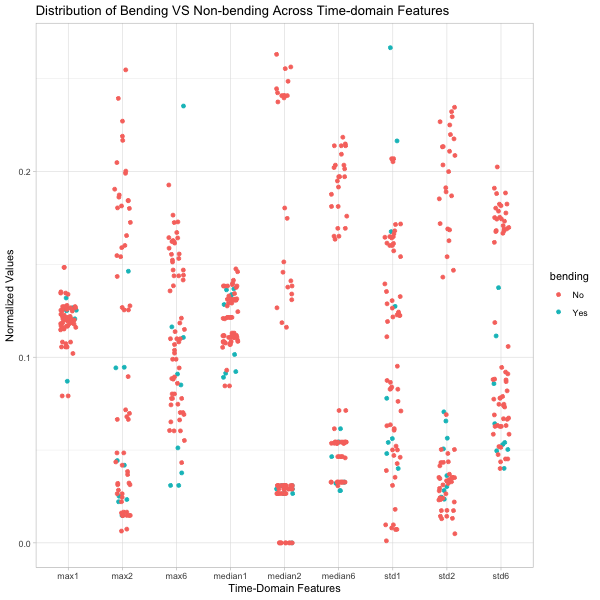

In [27]:
Image('./HW3_image/d1.png')

In [28]:
# (d) ii. Break the time series into two part and repeat (d)i.

first_file2 = pd.read_csv(all_files[0], skiprows=4, usecols=[1,2,3,4,5,6])
first_file2b = pd.concat([first_file2[:240].reset_index(drop=True), first_file2[240:].reset_index(drop=True)], axis=1)
first_file_long2 = first_file2b.describe().T[['max', '50%', 'std']].reset_index(drop=True)

In [29]:
colnames2 = [['max'+str(x), 'median'+str(x), 'std'+str(x)] for x in range(1,13)]
colnames2 = list(chain.from_iterable(colnames2))

In [30]:
df_desired2 = pd.DataFrame(first_file_long2.to_numpy().reshape(1,-1), columns=colnames2)
df_desired2

,max1,median1,std1,max2,median2,std2,max3,median3,std3,max4,median4,std4,max5,median5,std5,max6,median6,std6,max7,median7,std7,max8,median8,std8,max9,median9,std9,max10,median10,std10,max11,median11,std11,max12,median12,std12
0,42.330,41.250,1.103,1.220,0.470,0.328,25.670,18.000,4.063,7.230,0.430,0.818,36.170,34.500,1.212,1.500,0.000,0.648,45.000,39.415,1.717,1.300,0.430,0.317,29.500,21.500,4.433,5.500,0.820,1.039,38.250,35.415,2.838,1.920,0.430,0.510


In [31]:
for file in all_files[1:]:
    temp_df = pd.read_csv(file, skiprows=4, usecols=[1,2,3,4,5,6])
    temp_df = pd.concat([temp_df[:240].reset_index(drop=True), temp_df[240:].reset_index(drop=True)], axis=1)
    temp_file_long = temp_df.describe().T[['max', '50%', 'std']].reset_index(drop=True)
    df_desired2 = pd.concat([df_desired2, pd.DataFrame(temp_file_long.to_numpy().reshape(1,-1), columns=colnames2)])

In [32]:
df_desired2.reset_index(drop=True, inplace=True)
df_desired2.head()

,max1,median1,std1,max2,median2,std2,max3,median3,std3,max4,median4,std4,max5,median5,std5,max6,median6,std6,max7,median7,std7,max8,median8,std8,max9,median9,std9,max10,median10,std10,max11,median11,std11,max12,median12,std12
0,42.330,41.250,1.103,1.220,0.470,0.328,25.670,18.000,4.063,7.230,0.430,0.818,36.170,34.500,1.212,1.500,0.000,0.648,45.000,39.415,1.717,1.300,0.430,0.317,29.500,21.500,4.433,5.500,0.820,1.039,38.250,35.415,2.838,1.920,0.430,0.510
1,44.250,42.500,0.642,0.940,0.470,0.258,25.330,21.000,2.693,5.500,0.430,0.904,36.000,33.710,1.309,1.500,0.430,0.625,45.670,43.375,1.913,1.220,0.470,0.317,29.500,21.125,4.794,5.760,0.830,1.128,38.500,32.000,2.284,3.110,0.430,0.575
2,46.500,44.500,1.557,1.500,0.470,0.330,29.250,24.000,2.411,2.740,0.430,0.498,38.500,36.250,1.316,1.790,0.500,0.527,47.400,43.500,1.557,1.700,0.500,0.342,29.750,20.625,3.270,4.440,0.430,0.599,38.250,36.000,2.299,1.500,0.000,0.479
3,47.750,45.000,3.473,3.000,0.485,0.634,30.000,23.750,3.123,4.770,0.710,0.769,38.670,36.000,1.650,1.530,0.765,0.555,46.000,42.000,3.537,2.860,0.500,0.628,29.250,22.000,4.184,5.150,0.870,1.079,38.500,30.415,3.760,2.180,0.470,0.492
4,45.750,42.330,3.119,2.830,0.500,0.490,28.250,19.500,5.103,6.420,0.825,1.171,37.500,30.000,2.701,1.790,0.430,0.411,43.670,41.500,0.596,1.120,0.500,0.273,24.000,19.000,2.725,2.350,0.470,0.456,36.000,29.750,2.063,1.500,0.430,0.363


In [33]:
col_num = df_desired2.shape[1]
df_desired2['target'] = target
df_desired2['test'] = df_desired2.index.isin([0,1,7,8,13,14,15,28,29,30,43,44,45,58,59,60,73,74,75])
test2 = df_desired2.loc[df_desired2['test']==True].drop('test', axis=1)
train2 = df_desired2.loc[df_desired2['test']==False].drop('test', axis=1)

In [34]:
nml = Normalizer()
train2.iloc[:, :col_num] = nml.fit_transform(train2.iloc[:, :col_num].T).T 
test2.iloc[:, :col_num] = nml.transform(test2.iloc[:, :col_num].T).T

In [35]:
train2.loc[:, 'target'] = train2['target'].astype('category')
test2.loc[:, 'target'] = test2['target'].astype('category')

In [36]:
dii_scatter = train2.loc[:, ['max1','median1','std1','max2','median2','std2','max12','median12','std12','target']]
dii_scatter['bending'] = np.where(dii_scatter['target']=='bending', 'Yes', 'No')

In [37]:
%%R -i dii_scatter

g = dii_scatter %>%
    gather(-one_of(c('target', 'bending')), key='variable', value='value')

g$variable = ordered(g$variable, levels=c('max1','max2','max12','median1',
                                          'median2','median12','std1','std2','std12'))

gg = ggplot(g, aes(variable, value)) +
        geom_jitter(aes(col=bending), width=.15) +
        labs(title='Distribution of Bending VS Non-bending Across (Doubled) Time-domain Features',
             x='Time-Domain Features',
             y='Normalized Values')

png(file='./HW3_image/d2.png', width=600, height=600)
gg

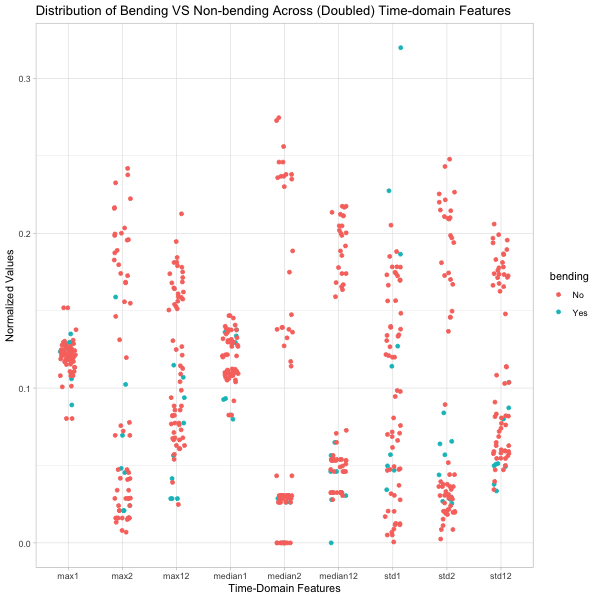

In [38]:
Image('./HW3_image/d2.png')

It seems like the values are stretched a little bit further on the y-axis. \
Otherwise the two distributions look similar to each other.

In [39]:
# (d) iii. break up time series into different partitions

def get_sliced_time_series(l, binary=True, train_only=True, case_control=False, normalize=False):
    
    '''
    Get desired training set and testing set with l splitting of time series.
    Time-domain features (min, max, std, mean, median) are extracted and normalized accordingly.
    Return pandas dataframes / series for ML purpose.
    
    Parameters:
    l : int
        Determine the number of splits.
    binary : bool (default = True)
        Determine whether it's binary or multiclass classification.
    train_only : bool (default = True)
        Whether to return training sets only.
    case_control : bool (default = False)
        Whether to restrict certain non-bending instances.
    normalize : bool (default = False)
        Whether to use Normalizer or MinMaxScaler.    
    '''
    
    first_file = pd.read_csv(all_files[0], skiprows=4, usecols=[1,2,3,4,5,6])
    slice_index = range(0, 499, int(np.ceil(480/l))) # Ensure proper splitting
    zipped_slice_index = list(zip(slice_index, slice_index[1:]))
    first_file = pd.concat([first_file[x:y].reset_index(drop=True) for x,y in zipped_slice_index], axis=1)
    first_file_long = first_file.describe().T[['max', '50%', 'std', 'mean', 'min']].reset_index(drop=True)
    colnames = [['max'+str(x), 'median'+str(x), 'std'+str(x), 'mean'+str(x), 'min'+str(x)] for x in range(1,1+l*6)]
    colnames = list(chain.from_iterable(colnames))
    df_desired = pd.DataFrame(first_file_long.to_numpy().reshape(1,-1), columns=colnames)

    for file in all_files[1:]: # Concatenate to the dataframe iteratively
        temp_df = pd.read_csv(file, skiprows=4, usecols=[1,2,3,4,5,6])
        temp_df = pd.concat([temp_df[x:y].reset_index(drop=True) for x,y in zipped_slice_index], axis=1)
        temp_file_long = temp_df.describe().T[['max', '50%', 'std', 'mean', 'min']].reset_index(drop=True)
        df_desired = pd.concat([df_desired, pd.DataFrame(temp_file_long.to_numpy().reshape(1,-1), columns=colnames)])

    df_desired.reset_index(drop=True, inplace=True)
    col_num = df_desired.shape[1]
    df_desired['target'] = target
    df_desired['test'] = df_desired.index.isin([0,1,7,8,13,14,15,28,29,30,43,44,45,58,59,60,73,74,75])
    test = df_desired.loc[df_desired['test']==True].drop('test', axis=1) # Train-test split
    if case_control: # Selectively drop 15 non-bending instances
        train = df_desired.loc[df_desired['test']==False].drop('test', axis=1)
        train = train.iloc[train.index.isin(np.r_[2:7,9:13,19:28,34:43,49:58,64:73,79:88])]
    else:
        train = df_desired.loc[df_desired['test']==False].drop('test', axis=1)
    
    if normalize: # Normalize each feature
        nml = Normalizer() 
        train.iloc[:, :col_num] = nml.fit_transform(train.iloc[:, :col_num].T).T 
        test.iloc[:, :col_num] = nml.transform(test.iloc[:, :col_num].T).T
    else: # Min-max scale each feature
        from sklearn.preprocessing import MinMaxScaler
        mms = MinMaxScaler()
        train.iloc[:, :col_num] = mms.fit_transform(train.iloc[:, :col_num]) 
        test.iloc[:, :col_num] = mms.transform(test.iloc[:, :col_num])

    if binary: # Create binary variable
        train['bending'] = np.where(train['target']=='bending', 1, 0)
        test['bending'] = np.where(test['target']=='bending', 1, 0)
        train.drop('target', axis=1, inplace=True)
        test.drop('target', axis=1, inplace=True)
    else: # Create multiclass variable
        from sklearn.preprocessing import LabelEncoder
        lbl = LabelEncoder()
        train['target'] = lbl.fit_transform(train['target'])
        test['target'] = lbl.transform(test['target'])

    X_train = train.iloc[:, :col_num]
    y_train = train.iloc[:, -1]
    X_test  = test.iloc[:, :col_num]
    y_test  = test.iloc[:, -1]
    
    if train_only:
        return (X_train, y_train)
    else:
        return (X_train, y_train, X_test, y_test)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

count_dict = {}
for l in range(1,21):
    X_train, y_train = get_sliced_time_series(l) # Get the sliced time series
    
    logreg = LogisticRegression(C=10000, solver='lbfgs')
    rfecv = RFECV(logreg, cv=5) # StratifiedKFold is automatically applied for binary data
    selector = rfecv.fit(X_train, y_train)
    
    # Create a dictionary with key as number of slices, and value as a list containing:
    # 1) A feature vector boolean
    # 2) Number of feature used
    # 3) The highest cv-score
    
    count_dict[l] = [selector.support_, sum(selector.support_), max(selector.grid_scores_)]

The wrong way is to only perform cross-validation after choosing a specific l, the correct way is to choose (l, p) simultaneously using cross-validation.

In [41]:
# Find the best cv-score

[count_dict[x][2] for x in range(1,21)] # We'll proceed with l = 1
count_dict[1][1]
get_sliced_time_series(1)[0].columns[count_dict[1][0]]

[0.9714285714285715,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9417582417582417,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9274725274725275,
 0.9714285714285715,
 0.9714285714285715,
 0.9428571428571428,
 0.9571428571428573,
 0.956043956043956,
 0.9571428571428573,
 0.9714285714285715,
 0.9274725274725275]

2

Index(['max5', 'min5'], dtype='object')

The best classifier chosen is (l, p) = (1, 2), the chosen parameters are **(max5, min5)**.

In [42]:
# (d) iv. Refit rfecv for l = 19 and get prediction on train and test set

X_train, y_train, X_test, y_test = get_sliced_time_series(1, train_only=False)
logreg = LogisticRegression(C=10000, solver='lbfgs', warm_start=True)
rfecv = RFECV(logreg, cv=5)
selector = rfecv.fit(X_train, y_train)
y_pred_train = selector.predict(X_train)
y_pred_test = selector.predict(X_test)

In [43]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

confusion_matrix(y_train, y_pred_train)

# Note that Negative == Non-bending, Positive == Bending
# Get the True Negative, False Positive, False Negative and True Positive accordingly
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel() # Flatten the matrix
confusion_matrix_flatten = (tn, fp, fn, tp)
confusion_matrix_flatten

array([[60,  0],
       [ 0,  9]])

(60, 0, 0, 9)

There are 60 True Positives and 9 True Negatives with no error.

In [44]:
# Get ROC

y_proba_train = selector.predict_proba(X_train)
y_proba_train_pos = [x[1] for x in y_proba_train]
fpr, tpr, _ = roc_curve(y_train, y_proba_train_pos, pos_label=1)

In [45]:
roc_curve = pd.DataFrame(np.column_stack([tpr, fpr]),
                         columns=['tpr', 'fpr'])

In [46]:
%%R -i roc_curve

gg = ggplot(roc_curve, aes(fpr, tpr)) +
        geom_line() +
        geom_abline(slope=1, intercept=0, linetype='dashed', col='tomato2') +
        labs(title='ROC Curve on Train Data',
             x='False Positive Rate',
             y='True Positive Rate')

png(file='./HW3_image/roc.png', width=500, height=500)
gg

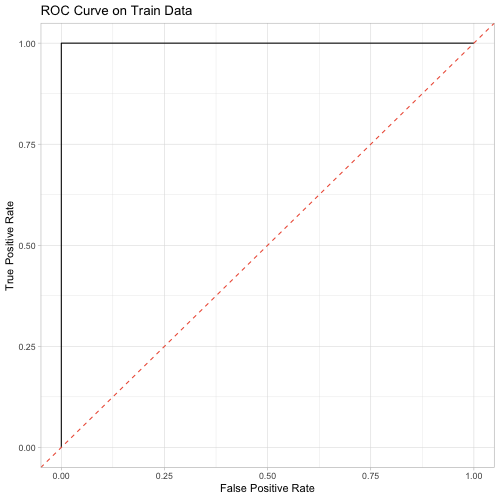

In [47]:
Image('./HW3_image/roc.png')

In [48]:
# Get the AUC score, which is clearly 1

roc_auc_score(y_train, y_proba_train_pos)

1.0

The AUC score is 1.

In [49]:
X_train, y_train = get_sliced_time_series(1)

In [50]:
# Get the parameter estimates and p-values

logreg_r = pd.DataFrame(np.column_stack([X_train.loc[:, 'max5'], X_train.loc[:, 'min5'], y_train]),
                        columns=['max5', 'min5', 'bending'])

In [51]:
%%R -i logreg_r

summary(glm(bending ~ ., data=logreg_r, family='binomial'))


Call:
glm(formula = bending ~ ., family = "binomial", data = logreg_r)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-2.245e-04  -2.100e-08  -2.100e-08  -2.100e-08   1.610e-04  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -1160     186885  -0.006    0.995
max5            1270     205115   0.006    0.995
min5            1775     287220   0.006    0.995

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5.3435e+01  on 68  degrees of freedom
Residual deviance: 8.9234e-08  on 66  degrees of freedom
AIC: 6

Number of Fisher Scoring iterations: 25



Due to perfect separation, the vanilla logistic regression estimates and standard errors becomes **very unstable**, and therefore meaningless.

In [52]:
# (d) v. Get prediction score on the test set

selector.score(X_test, y_test)

0.8947368421052632

The accuracy score drops a bit from the cross validation accuracy, from 0.9714 to 0.8947. With the two chosen features, **lowering max-iter in Logistic Regression could not help because the target is linearly separable.**

In [53]:
# (d) vi. Instablility in calculating logistic regression parameter

Yes, as stated above.

In [54]:
# (d) vii. Case-control sampling

confusion_matrix_flatten

(60, 0, 0, 9)

It's clear that we suffer from class imbalance here, let's downsample our non-bending case to ~4 times that of our bending case. 

In [55]:
count_dict2 = {}
for l in range(1,21):
    X_train, y_train = get_sliced_time_series(l, case_control=True) # Get the case control slices
    
    logreg = LogisticRegression(C=10000, solver='lbfgs')
    rfecv = RFECV(logreg, cv=5)
    selector = rfecv.fit(X_train, y_train)
    count_dict2[l] = [selector.support_, sum(selector.support_), max(selector.grid_scores_)]

In [56]:
# Find the best cv-score

[count_dict[x][2] for x in range(1,21)] # We'll proceed with l = 1
count_dict[1][1]
get_sliced_time_series(1)[0].columns[count_dict[1][0]]

[0.9714285714285715,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9417582417582417,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9571428571428573,
 0.9274725274725275,
 0.9714285714285715,
 0.9714285714285715,
 0.9428571428571428,
 0.9571428571428573,
 0.956043956043956,
 0.9571428571428573,
 0.9714285714285715,
 0.9274725274725275]

2

Index(['max5', 'min5'], dtype='object')

In [57]:
X_train, y_train, X_test, y_test = get_sliced_time_series(1, train_only=False, case_control=True)
logreg = LogisticRegression(C=10000, solver='lbfgs', warm_start=True)
rfecv = RFECV(logreg, cv=5)
selector = rfecv.fit(X_train, y_train)
y_pred = selector.predict(X_test)

In [58]:
# Confusion Matrix on test set

confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
confusion_matrix_flatten = (tn, fp, fn, tp)
confusion_matrix_flatten

array([[15,  0],
       [ 0,  4]])

(15, 0, 0, 4)

We have 15 True Negatives and 4 True Positives with no error.

In [59]:
# ROC on test set
from sklearn.metrics import roc_curve

y_proba_test = selector.predict_proba(X_test)
y_proba_test_pos = [x[1] for x in y_proba_test]
fpr, tpr, _ = roc_curve(y_test, y_proba_test_pos, pos_label=1)

In [60]:
roc_curve2 = pd.DataFrame(np.column_stack([tpr, fpr]),
                          columns=['tpr', 'fpr'])

In [61]:
%%R -i roc_curve2

gg = ggplot(roc_curve2, aes(fpr, tpr)) +
        geom_line() +
        geom_abline(slope=1, intercept=0, linetype='dashed', col='tomato2') +
        labs(title='ROC Curve on Test Data with Case-control Sampling',
             x='False Positive Rate',
             y='True Positive Rate')

png(file='./HW3_image/roc2.png', width=500, height=500)
gg

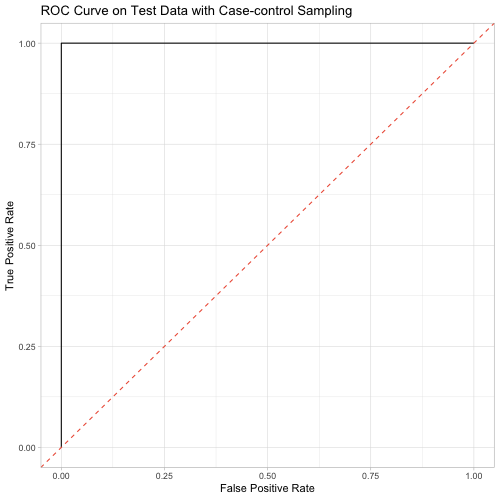

In [62]:
Image('./HW3_image/roc2.png')

In [63]:
# AUC on test set

roc_auc_score(y_test, y_proba_test_pos)

1.0

The AUC score is 1. \
Performing case-control sampling helps with test accuracy.

In [64]:
# (e) i. L1-Penalized Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

best_C = [] # Get the 20 Cs selected for l ranging from 1 to 20
best_cv_score = [] # Get the 20 cv-scores corresponding to the best C selected for l ranging from 1 to 20
for l in range(1,21):
    X_train, y_train = get_sliced_time_series(l) # Get the sliced time series
    logregcv = LogisticRegressionCV(Cs=np.logspace(-1, 1, 100), # 100 candidates for C instead of the default 10
                                    cv=5,
                                    penalty='l1', 
                                    solver='saga', # Compatible with L1 regularization
                                    n_jobs=-1,
                                    class_weight='balanced', # Deal with class inbalance
                                    max_iter=10000)
    logregcv.fit(X_train, y_train)
    C_index = np.where(logregcv.Cs_ == logregcv.C_)[0][0]
    best_C.append(logregcv.C_[0])
    best_cv_score.append(np.mean(list(zip(*logregcv.scores_[1]))[C_index]))

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=-1,
                     penalty='l1', random_state=None, refit=True, scoring=None,
                     solver='saga

In [65]:
best_cv_score # Seems like l = 1 is a good fit
best_C # The corresponding C is 2.420128264794382

[0.9714285714285715,
 0.9714285714285715,
 0.9714285714285715,
 0.9571428571428573,
 0.9428571428571428,
 0.9714285714285715,
 0.9714285714285715,
 0.9560439560439562,
 0.9428571428571428,
 0.9428571428571428,
 0.9571428571428571,
 0.9285714285714286,
 0.9571428571428571,
 0.9714285714285715,
 0.9131868131868132,
 0.9274725274725275,
 0.9428571428571428,
 0.9571428571428571,
 0.9571428571428573,
 0.9571428571428573]

[0.22051307399030456,
 0.22051307399030456,
 0.9770099572992254,
 3.5938136638046276,
 0.6734150657750824,
 0.464158883361278,
 0.40370172585965547,
 0.464158883361278,
 0.5094138014816381,
 0.4862601580065355,
 0.4229242874389499,
 4.328761281083059,
 0.6135907273413174,
 0.22051307399030456,
 0.5094138014816381,
 0.38535285937105296,
 0.33516026509388425,
 0.35111917342151316,
 0.2104904144512021,
 0.2104904144512021]

The best (l, C) is found to be (1, 0.22051307399030456)

In [66]:
# (e) ii. comparison between two variable selection methods
# refit the model using the best params

X_train, y_train, X_test, y_test = get_sliced_time_series(1, train_only=False) 
logreg_l1 = LogisticRegression(C=0.22051307399030456, 
                               penalty='l1', 
                               solver='saga',
                               class_weight='balanced',
                               n_jobs=-1,
                               max_iter=10000)
logreg_l1.fit(X_train, y_train)

LogisticRegression(C=0.22051307399030456, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
# Get accuracy score and confusion matrix

logreg_l1.score(X_test, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, logreg_l1.predict(X_test)).ravel() # Flatten the matrix
confusion_matrix_flatten = (tn, fp, fn, tp)
confusion_matrix_flatten

1.0

(15, 0, 0, 4)

P-values have not been used to perform variable selection. However, we can very much **treat as if our backward selection used p-values as variables-in and variable-out criteria.**

We have a perfect accuracy score in L1-regularized logistic regression, which is higher than 0.8947, the score obtained through variable selection using p-values. However, **a perfect score is achievable using case-control sampling as well.**

In terms of implementation, the **regularized regression is easier**, the **computation is lighter** because regularized regression undergoes a fixed number of cv given the fixed parameter grid of lambdas (although convergence time increases substantially with increasing features too). In contrast, backward selection with lots of features becomes very time consuming.

In [68]:
# (f) i. Multiclass classification

best_C = []
best_cv_score = []
for l in range(1, 21):
    X_train, y_train = get_sliced_time_series(l, binary=False)
    logregcv_mc = LogisticRegressionCV(Cs=np.logspace(-1, 1, 100), 
                                       cv=5,
                                       penalty='l1', 
                                       solver='saga', 
                                       multi_class='auto', # Multiclass classification
                                       n_jobs=-1,
                                       max_iter=10000)
    logregcv_mc.fit(X_train, y_train)
    C_index = np.where(logregcv_mc.Cs_ == logregcv_mc.C_[0])[0][0]
    best_C.append(logregcv_mc.C_[0])
    best_cv_score.append(np.mean(list(zip(*logregcv_mc.scores_[1]))[C_index]))

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

LogisticRegressionCV(Cs=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.30538555,
        0.31992671,  0.33516027,  0.35111917,  0.36783798,  0.3853528...
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ]),
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol

In [69]:
best_cv_score # Seems like l = 2 is a good fit
best_C # The corresponding C is 9.111627561154895

[0.9098039215686274,
 0.9264705882352942,
 0.8749554367201424,
 0.8196078431372549,
 0.8499108734402853,
 0.8680926916221035,
 0.8396613190730837,
 0.7994652406417113,
 0.8278966131907307,
 0.8014260249554367,
 0.7832442067736185,
 0.7999108734402853,
 0.7763814616755794,
 0.7896613190730839,
 0.7601604278074866,
 0.7945632798573976,
 0.7960784313725491,
 0.8196078431372549,
 0.7960784313725491,
 0.8063279857397504]

[6.892612104349698,
 9.111627561154895,
 0.6135907273413174,
 1.4174741629268055,
 5.462277217684343,
 0.8902150854450388,
 6.5793322465756825,
 3.764935806792469,
 3.5938136638046276,
 0.6428073117284322,
 1.4174741629268055,
 6.892612104349698,
 5.462277217684343,
 1.484968262254465,
 0.9770099572992254,
 2.1544346900318843,
 0.8497534359086445,
 1.2328467394420666,
 0.7054802310718644,
 5.214008287999687]

In [70]:
# refit using the best params

X_train, y_train, X_test, y_test = get_sliced_time_series(2, train_only=False, binary=False) 
logregmc_l1 = LogisticRegression(C=9.111627561154895, 
                                 penalty='l1', 
                                 solver='saga', 
                                 multi_class='auto',
                                 n_jobs=-1,
                                 max_iter=10000)
logregmc_l1.fit(X_train, y_train)

LogisticRegression(C=9.111627561154895, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
# Get the accuracy score and the corresponding test error

logregmc_l1.score(X_test, y_test)
1 - logregmc_l1.score(X_test, y_test)

0.7368421052631579

0.26315789473684215

The accuracy score is 0.737 and the test error is 0.263

In [72]:
# Get the confusion matrix

y_pred = logregmc_l1.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3, 0, 0, 1, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [1, 0, 0, 0, 2, 0],
       [0, 0, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 3]])

In [73]:
y_test_r = y_test.values

The **diagonal entries represent correct predictions**, while the off-diagonal ones represent otherwise.

In the above example, we can see that none of the three class 3 samples (lying) is correctly classified. One of them is classified as class 0 (bending), while the remaining two are classified as class 4 (sitting).

In [74]:
%%R -i y_pred,y_test_r

# Get the multiclass AUC
multiclass.roc(y_test_r, y_pred)


Call:
multiclass.roc.default(response = y_test_r, predictor = y_pred)

Data: y_pred with 6 levels of y_test_r: 0, 1, 2, 3, 4, 5.
Multi-class area under the curve: 0.8759


**A multiclass AUC is a mean of several AUC**, which is obtained through a **one-vs-rest** approach through binarization of our target variable (analogous to bending-vs-non_bending).

We obtain a multi-class AUC of 0.8759, not bad.

In [75]:
# (f) ii. Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

score = []
for l in range(1, 21):
    X_train, y_train = get_sliced_time_series(l, binary=False)
    gnb = GaussianNB()
    score.append(cross_val_score(gnb, X_train, y_train, cv=5, n_jobs=-1)) # Get 5-fold cross-validation score

In [76]:
list(map(np.mean, score)) # Seems like l = 1 is the best

[0.8680926916221035,
 0.8278966131907308,
 0.7710338680926916,
 0.739572192513369,
 0.7793226381461675,
 0.7190730837789662,
 0.7710338680926916,
 0.781283422459893,
 0.6993761140819965,
 0.6993761140819965,
 0.7528520499108734,
 0.624331550802139,
 0.7062388591800357,
 0.6072192513368984,
 0.5689839572192513,
 0.6228163992869875,
 0.6130124777183601,
 0.5375222816399287,
 0.5929590017825312,
 0.5758467023172905]

The best *l* is found to be 1.

In [77]:
# Refit GNB

X_train, y_train, X_test, y_test = get_sliced_time_series(1, binary=False, train_only=False)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

GaussianNB(priors=None, var_smoothing=1e-09)

0.8947368421052632

GNB produces a test accuracy score of 0.8947

In [78]:
# Multinomial Naive Bayes
from sklearn.model_selection import GridSearchCV

# Hyperparameters to tune
params = {'alpha': np.logspace(-2, 2, 100)}

# Instantiate the classifier
best_score = []
best_param = []
for l in range(1, 21):
    X_train, y_train = get_sliced_time_series(l, binary=False)
    mnb = MultinomialNB()
    mnb_cv = GridSearchCV(estimator=mnb,
                          param_grid=params,
                          cv=5, n_jobs=-1, iid=False) # Again, get 5-fold cv
    mnb_cv.fit(X_train, y_train)
    best_score.append(mnb_cv.best_score_)
    best_param.append(mnb_cv.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.0538...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
best_score # We'll use l = 5
best_param # the corresponding alpha is 3.5111917342151346

[0.7581996434937611,
 0.7631016042780748,
 0.7327094474153298,
 0.6993761140819965,
 0.7744206773618539,
 0.7744206773618539,
 0.7744206773618539,
 0.7680035650623885,
 0.7744206773618539,
 0.7646167557932265,
 0.7631016042780748,
 0.7528520499108735,
 0.769964349376114,
 0.7729055258467025,
 0.7581996434937611,
 0.739572192513369,
 0.7684491978609624,
 0.7577540106951872,
 0.7680035650623885,
 0.7597147950089127]

[{'alpha': 0.8697490026177834},
 {'alpha': 0.7924828983539177},
 {'alpha': 4.229242874389499},
 {'alpha': 4.229242874389499},
 {'alpha': 3.5111917342151346},
 {'alpha': 1.6681005372000592},
 {'alpha': 0.8697490026177834},
 {'alpha': 0.012045035402587823},
 {'alpha': 2.2051307399030455},
 {'alpha': 0.08497534359086446},
 {'alpha': 0.01},
 {'alpha': 0.1484968262254465},
 {'alpha': 0.01},
 {'alpha': 1.5199110829529348},
 {'alpha': 0.01},
 {'alpha': 1.261856883066021},
 {'alpha': 0.01},
 {'alpha': 0.49770235643321115},
 {'alpha': 0.37649358067924693},
 {'alpha': 0.010974987654930561}]

The best (*l*, $\alpha$) is found to be (5, 3.5111917342151346).

In [80]:
# Refit MNB

X_train, y_train, X_test, y_test = get_sliced_time_series(5, binary=False, train_only=False)
mnb = MultinomialNB(alpha=3.5111917342151346)
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

MultinomialNB(alpha=3.5111917342151346, class_prior=None, fit_prior=True)

0.8421052631578947

MNB produces a test accuracy score of 0.8421, a slightly worse accuracy score compared to what we have got for GNB.

It is natural that GNB performs better because **we have continuous variables here, which is a natural target for GNB.** Whereas MNB usually deals with discrete variables (such as word counts).

In [81]:
# (f) iii. Comparison of Logistic Regression, Gaussian NB and Multinomial NB

Test accuracies of the classifiers are as follows:
* Logistic Regression: 0.7368
* Multinomial Naive Bayes: 0.8421
* Gaussian Naive Bayes: **0.8947**

From the test **accuracy** perspective, **Gaussian Naive Bayes is the winner.** It makes sense to use GNB because the variables are continuous, although **it's a bit dangerous to assume our time-domain features have zero conditional correlation with each other.**

From the **computation** perspective, the **Naive Bayes approach is better than Regularized Logistic Regression**. Firstly, **Regularized Logistic Regression suffers from our small sample size** (69 instances in training set), with the situation exacerbated as *l* gets larger. Naive Bayes on the other hand handles this situation well, again because of the fact that we assume zero conditional correlation among features. Secondly, the **computation time of Multinomial Naive Bayes is three times less than that of Logistic Regression**, given the fact that both undergoes a grid search space of 20 (l) $\times$ 100 (hyper-parameter) $\times$ 5 (cv) = 10000.

In [82]:
# 2. ISLR 3.7.4

(a) Even though the underlying relationship between X and Y is linear, I would expect a lower training RSS for the cubic regression. This is because adding variables in linear regression could only produce better (or at least the same) results in terms of **train error**.

(b) Because the underlying relationship is linear, the cubic regression will likely overfits and therefore generalizes poorly on the test set, and hence having a higher test RSS.

(c) I would expect a lower training RSS for the cubic regression. The rationale is similar to part a, a more flexible model will only results in a lower training RSS.

(d) We don't have enough information to tell because **we don't know how far the true relationship is from linear**. If it is closer to linear than cubic, then linear regression might perform better, vice versa. It's **bias-variance trade off.**

In [83]:
# 3 & 4. ISLR 4.7.3, ISLR 4.7.7

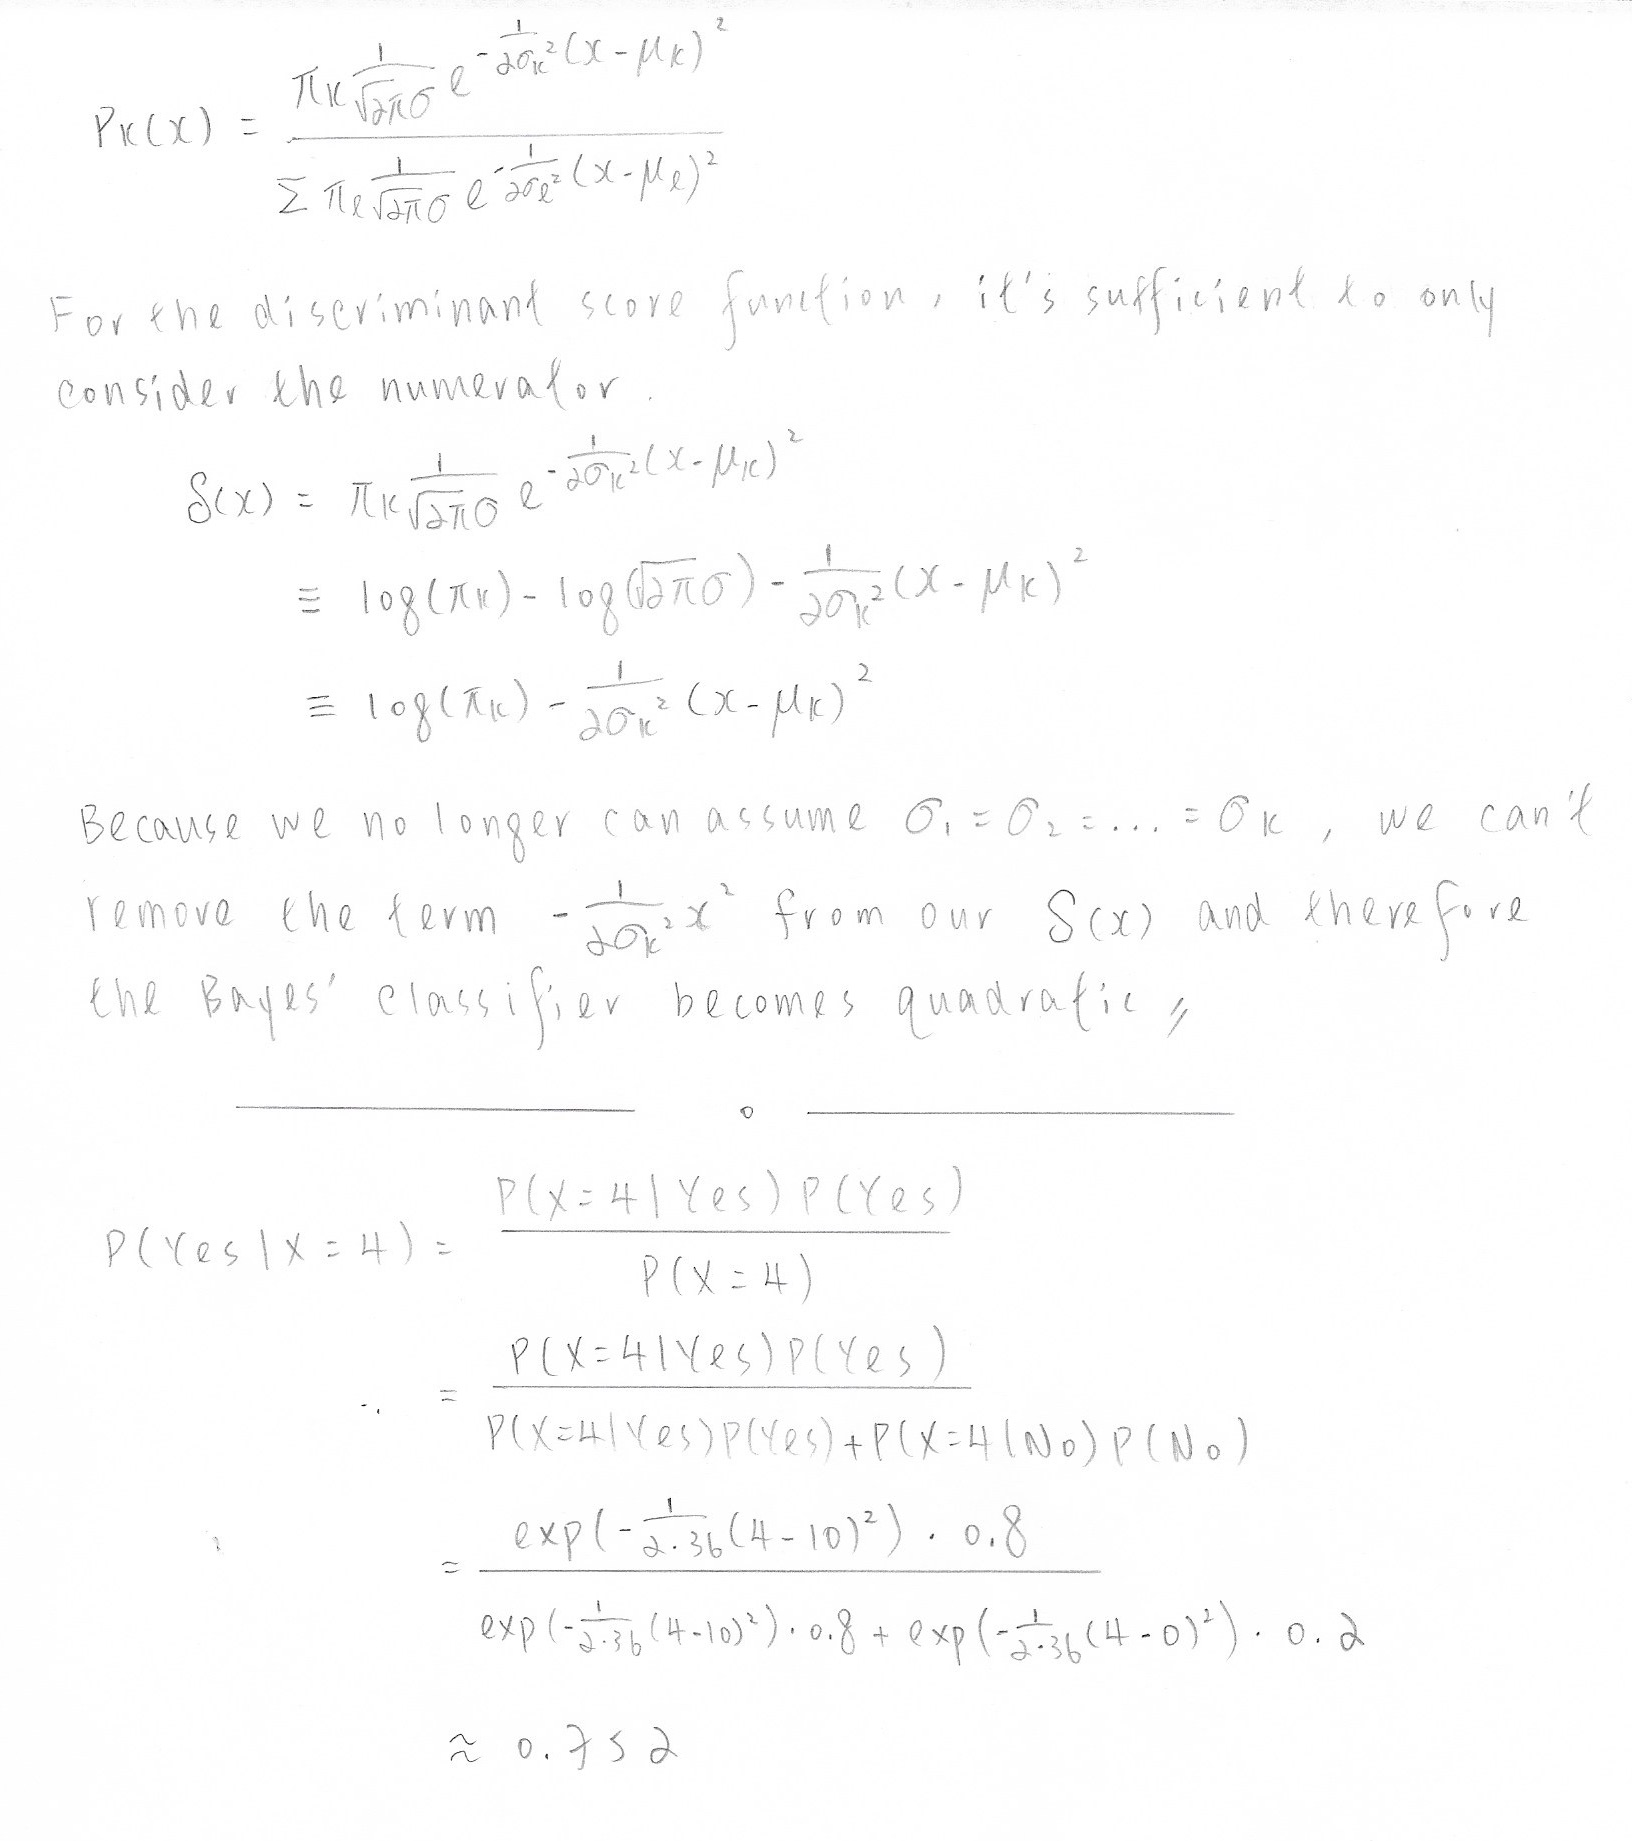

In [84]:
Image('./HW3_image/islr.jpg')